In [1]:
from skimage.graph import route_through_array
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
def get_closest(array, value):
    return np.abs(array - value).argmin()

# Load environmental data 

In [3]:
path = os.path.join('..','data','CMEMS','GLOBAL_ANALYSIS_FORECAST_WAV_001_027')
file = os.path.join(path,'mfwamglocep_2020120100_R20201202.nc')
file

'../data/CMEMS/GLOBAL_ANALYSIS_FORECAST_WAV_001_027/mfwamglocep_2020120100_R20201202.nc'

In [4]:
dataset = xr.open_dataset(file)
dataset

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 8)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2020-12-01T03:00:00 ... 2020-12-02
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
    VMDR_WW    (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VMDR_SW2   (time, latitude, longitude) float32 ...
    VTM01_SW2  (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
    VHM0_SW1   (time, latitude, longitude) float32 ...
    VHM0_SW2   (time, latitude, longitude) float32 ...
    VTPK       (time, latitude, longitude) float32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
    VPED       (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:                   CF-1.6
    time_coverage_start:           20201201-03:00:00
    time_coverage_end:             20201202-00:00:00
    date_created:                  20201202-06:35:00
    product_type:                  hindcast
    product:                       GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    product_ref_date:              20201201-00:00:00
    product_range:                 D-1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:   http://marine.copernicus.eu/documents/QUI...
    dataset:                       global-analysis-forecast-wav-001-027
    title:                         Mean fields from global wave model MFWAM o...
    institution:                   METEO-FRANCE
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    area:                          GLO
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            179.9167
    geospatial_lon_step:           0.08332825
    geospatial_lon_units:          degree
    geospatial_lat_min:            -80.0
    geospatial_lat_max:            90.0
    geospatial_lat_step:           0.08333588
    geospatial_lat_units:          degree

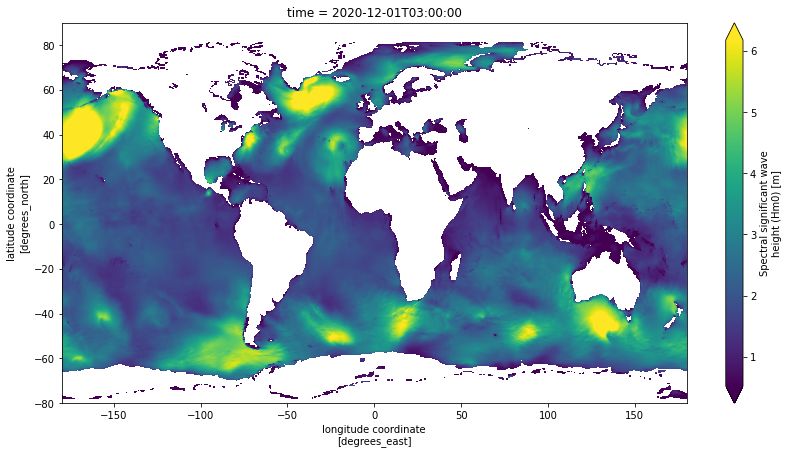

In [5]:
dataset.VHM0.isel(time=0).plot(robust=True, aspect=2, size=7);

# Define routing problem

Calculate the shipping route between New York and Lissabon avoiding high waves <br>

New York: 40.7128° N, 74.0060° W <br>
Lissabon: 38.7223° N, 9.1393° W

### Define area of interest

In [6]:
bbox = ((-80, 32),(-5, 47))
time_slice = 0

In [7]:
lon_min = get_closest(dataset.longitude.data, bbox[0][0])
lat_min = get_closest(dataset.latitude.data, bbox[0][1])
lon_max = get_closest(dataset.longitude.data, bbox[1][0])
lat_max = get_closest(dataset.latitude.data, bbox[1][1])

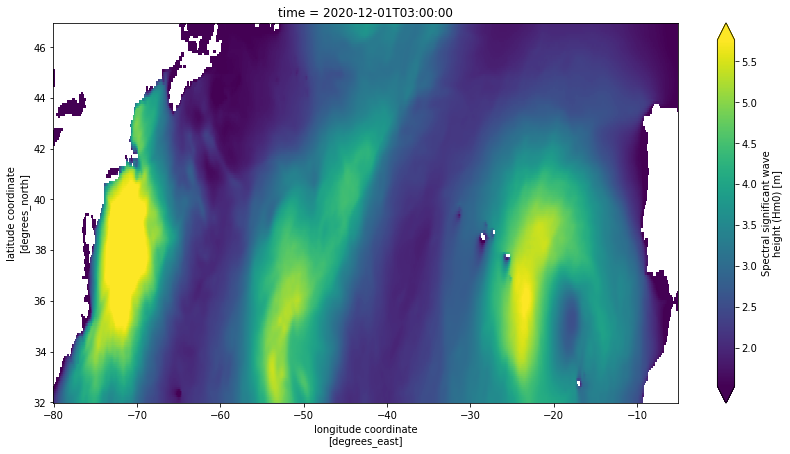

In [8]:
wave_height = dataset.VHM0.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_height.plot(robust=True, aspect=2, size=7);

In [9]:
image = wave_height.data
image[np.isnan(image)] = 2 * np.nanmax(image) # route_through_array cannot handle nan's
np.shape(image)

(180, 900)

### Define start/end point of route 

In [10]:
lat_NY = 40.7128
lon_NY = -74.0060
lat_LS = 38.7223
lon_LS = -9.1393

In [11]:
start_lon = get_closest(wave_height.longitude.data, lon_NY)
start_lat = get_closest(wave_height.latitude.data, lat_NY)
end_lon = get_closest(wave_height.longitude.data,lon_LS)
end_lat = get_closest(wave_height.latitude.data,lat_LS)

In [12]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

# Calculate route (lowest cost path)

In [13]:
# fully_connected - if True diagonal steps are allowed

indices, weight = route_through_array(image, start, end, fully_connected=True)
indices = np.stack(indices, axis=-1)
indices

array([[105, 105, 105, ...,  80,  80,  81],
       [ 72,  73,  74, ..., 848, 849, 850]])

In [14]:
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1

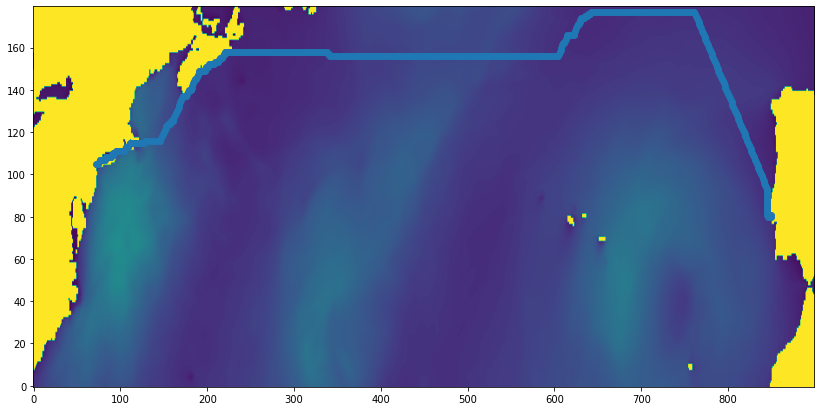

In [15]:
plt.figure(figsize=(14,7))
plt.imshow(image, aspect='auto');
plt.scatter(indices[1],indices[0])
#plt.imshow(path, aspect='auto', alpha=0.3);
plt.gca().invert_yaxis();